In [13]:
import math
import numpy as np
import pandas as pd
import math
from scipy.stats import mode
from timeit import default_timer
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta
import pandas as pd
import sys

In [18]:
def generate_prob(D, c, e, h, k, n_values=5):

    # Discretization steps
    a_values = np.linspace(0, 1, n_values, endpoint=True)
    d_values = np.linspace(0, 1, n_values, endpoint=True)

    f = lambda d, theta: (1-theta)*D - c*d
    g = lambda a, theta: theta*D - e*a

    balpha = lambda d,a: 1.0 + np.exp(a - 10.0*d)
    bbeta  = lambda d,a: 1.0 + np.exp(10.0*d - a)

    prob = lambda d, a, size=1: np.random.beta( balpha(d,a), bbeta(d,a), size=size )

    c1 = 1 - np.exp(-h*D)
    c2 = 1 - np.exp(h*c)

    e1 = np.exp(-k*D)
    e2 = np.exp(k*e)

    ##
    h1 =   1 / (c1 - c2)
    h2 = -c2 / (c1 - c2)

    k1 =   1 / (e1 - e2)
    k2 = -e2 / (e1 - e2)

    d_util = lambda d, theta: h1*(1.0 - np.exp( -h * f(d,theta) ) ) + h2
    a_util = lambda a, theta: k1*(np.exp(-k * g(a,theta) )) + k2

    return a_values, d_values, a_util, d_util, prob, balpha, bbeta

In [19]:
def plot_beta(balpha, bbeta, ax=None):
    mean = beta.stats(balpha, bbeta, moments='m')
    bx = np.linspace(beta.ppf(0.01, balpha, bbeta), beta.ppf(0.99, balpha, bbeta), 100)
    ax.plot(bx, beta.pdf(bx, balpha, bbeta), 'r-', lw=5, alpha=0.6)
    #ax.set_title("beta: alpha={:.2f}, beta={:.2f}\n mean={:.4f}".format(balpha, bbeta, mean))

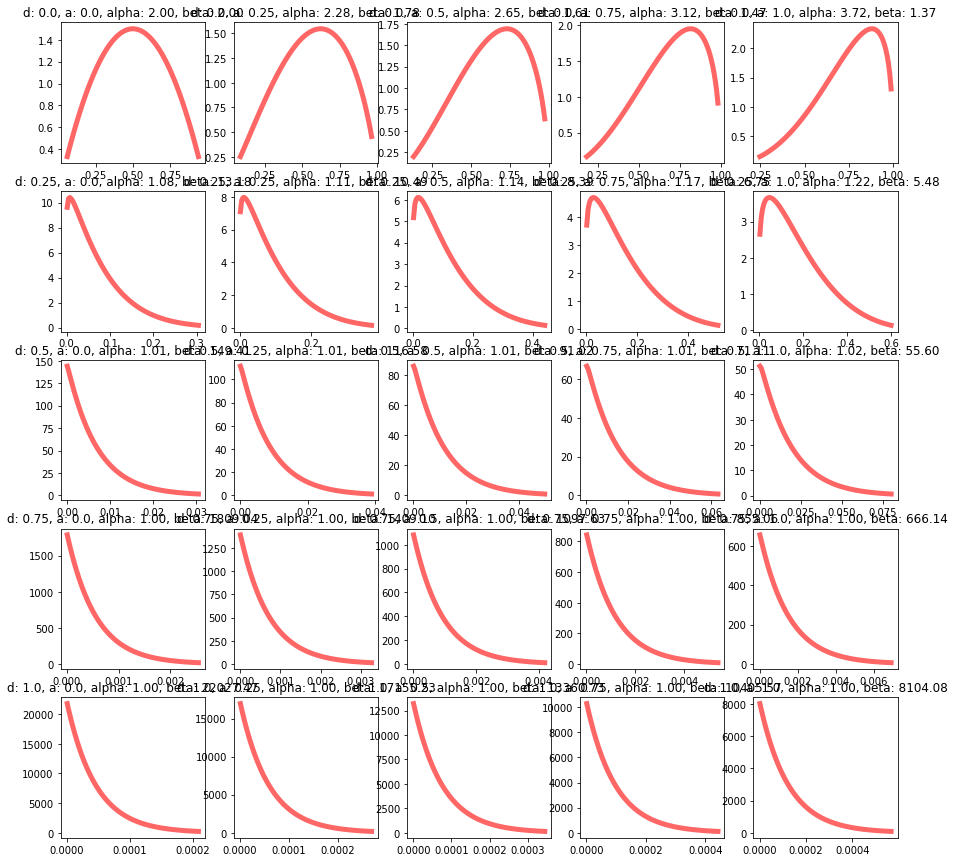

In [22]:
params = (10, 50, 1, 1.0, 0.001)
a_values, d_values, a_util, d_util, prob, balpha, bbeta = generate_prob(*params, n_values=5)

res = []
fig, ax = plt.subplots(len(d_values), len(a_values), figsize=(15, 15))
for i, d in enumerate(d_values):
    for j, a in enumerate(a_values):
        theta = prob(d, a, size=1000)
        res.append([d, a, balpha(d, a), bbeta(d, a), d_util(d, theta).mean(), a_util(a, theta).mean() ])
        plot_beta(balpha(d, a), bbeta(d, a), ax=ax[i, j])
        ax[i, j].set_title("d: {}, a: {}, alpha: {:.2f}, beta: {:.2f}".format(d, a, balpha(d, a), bbeta(d, a)))


df = pd.DataFrame(res, columns=['d', 'a', 'alpha', 'beta', 'd_util', 'a_util'])

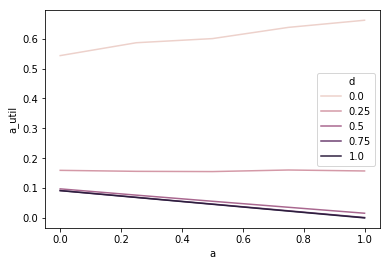

In [23]:
%matplotlib inline
import seaborn as sns

sns.lineplot(x='a', y='a_util', hue='d', data=df, legend='full');

In [24]:
def loss(x):

    a_values, d_values, a_util, d_util, prob, _, _ = generate_prob(*tuple(x))

    def solve(d_given, mcmc_iters=100000):
        psi_a = np.zeros(len(a_values), dtype=float)

        start = default_timer()
        for j, a in enumerate(a_values):
            theta_a = prob(d_given, a, size=mcmc_iters)
            psi_a[j] = a_util(a, theta_a).mean()
        end = default_timer()
        a_opt = a_values[psi_a.argmax()]

        return a_opt

    return -(abs(solve(0) - solve(1)))

In [27]:
params = (1000, 50, 10, 1.0, 0.01)
x0 = np.array(params)

res = minimize(loss, x0,
               bounds=[(0, None), (0, None), (0, None), (0, None), (0, None)])

print(res.x)
print(res.success)
print(res.fun)

[1.e+03 5.e+01 1.e+01 1.e+00 1.e-02]
True
-0.0


In [29]:
res = minimize(loss, np.ones(len(params)),
               bounds=[(0, None), (0, None), (0, None), (0, None), (0, None)])

print(res.x)
print(res.success)
print(res.fun)

[1. 1. 1. 1. 1.]
True
-0.0
